In [18]:
%%html

<h1> <center> USD - NTD - PHP </center></h1>
<h1> <center> Exchange Rate Monitoring System </center></h1>
<p> <center> John Olan S. Gomez </center> </p>
<p> <center> 111118013 </center> </p>
<p> <center> Modern Programming Language </center></p> 

USD - NTD - PHP 
 Exchange Rate Monitoring System 
 John Olan S. Gomez 
 111118013 
 Modern Programming Language

In [4]:
#add necessary libraries
import requests as req
from bs4 import BeautifulSoup as bs
from IPython.core.display import display, HTML

#urls to get the data
UStoNTNow= "https://www.exchangerates.org.uk/Dollars-to-Taiwan-Dollar-currency-conversion-page.html"
UStoPHNow= "https://www.exchangerates.org.uk/Dollars-to-Philippine-Pesos-currency-conversion-page.html"
NTtoPHNow= "https://www.exchangerates.org.uk/Taiwan-Dollar-to-Philippine-Pesos-currency-conversion-page.html"

#make an http request
UNreq= req.get(UStoNTNow)
PHreq= req.get(UStoPHNow)
NPreq= req.get(NTtoPHNow)

#parse the website using Beautiful Soup
UNsp= bs(UNreq.text, 'lxml')
PHsp= bs(PHreq.text, 'lxml')
NPsp= bs(NPreq.text, 'lxml')

#find the div with the exchange rate value
UNdiv= UNsp.find_all('div', class_='p_conv30')
PHdiv= PHsp.find_all('div', class_='p_conv30')
NPdiv= NPsp.find_all('div', class_='p_conv30')

#find the data
UNdata= UNdiv[1].text
PHdata= PHdiv[1].text
NPdata= NPdiv[1].text

#extract only the exchange value
UNdata= UNdata.split("= ",1)[1]
PHdata= PHdata.split("= ",1)[1]
NPdata= NPdata.split("= ",1)[1]

#print the data
UNdata = "1 USD = "+ str(UNdata.replace('TWD','NTD'))
PHdata = "1 USD = "+ str(PHdata)
NPdata = "1 NTD = "+ str(NPdata)

display(HTML(f"<center><h1>Current Exchange Rates</h1></center>"))
display(HTML(f"<center><h2>{UNdata}</h2></center>"))
display(HTML(f"<center><h2>{PHdata}</h2></center>"))
display(HTML(f"<center><h2>{NPdata}</h2></center>"))




Current Exchange Rates

1 USD = 30.6387 NTD

1 USD = 56.333 PHP

1 NTD = 1.8386 PHP

In [3]:

import sqlite3 as sql
import requests as req
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML

#create database
conn= sql.connect('forex.db')
print("Connected to database successfully")

#create cursor
c= conn.cursor()
sumVal = 0

dates= []
histDataUsdNtd= []

def insertData(year, month, data, custom):
    with conn:  #commit the query
        c.execute("INSERT INTO ntd_data VALUES (:year, :month, :ex_rate, :custom_date)",
                {'year':year, 'month':month, 'ex_rate':data, 'custom_date':custom})

def getData():
    c.execute("SELECT ex_rate FROM ntd_data")
    return c.fetchall()

def getDate():
    c.execute("SELECT custom_date FROM ntd_data")
    return c.fetchall()

def removeAllData():
    with conn:
        c.execute("DELETE from ntd_data")

try: 
    # create table
    c.execute("""
                CREATE TABLE ntd_data(
                year integer,
                month integer,
                ex_rate real,
                custom_date text
                )
                """)

    for i in range(2011, 2023):
        for j in range(1, 13):

            if j <10:
                histDataReq= req.get("https://rate.bot.com.tw/cr/"+str(i)+"-0"+str(j))
                histDatasp= bs(histDataReq.text, 'lxml')
                histTable= histDatasp.find('table', class_="table table-striped table-bordered table-condensed table-hover biaxial-table")
                histData= histTable.find_all('td', class_="text-right cols2td")
                data= histData[0].text
                data = float(data)
                #insert data to database
                insertData(i, j, data, str(i)+'-'+str(j))
                sumVal+=float(data)

            else:
                histDataReq= req.get("https://rate.bot.com.tw/cr/"+str(i)+"-"+str(j))
                histDatasp= bs(histDataReq.text, 'lxml')
                histTable= histDatasp.find('table', class_="table table-striped table-bordered table-condensed table-hover biaxial-table")
                histData= histTable.find_all('td', class_="text-right cols2td")
                data = histData[0].text
                data = float(data)
                #insert data to database
                insertData(i, j, data, str(i)+'-'+str(j))
                sumVal+=float(data)

    for i in range(0, len(getData())):
        f= getData()[i]
        histDataUsdNtd.append(f[0])

    for i in range(0, len(getDate())):
        f= getDate()[i]
        dates.append(f[0])

except:
    for i in range(0, len(getData())):
        f= getData()[i]
        histDataUsdNtd.append(f[0])

    for i in range(0, len(getDate())):
        f= getDate()[i]
        dates.append(f[0])
    
    for i in histDataUsdNtd:
        sumVal+=i

finally:
    #plot the data
    # Specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(10,5))
    # Rotate the date ticks on the x-axis by degrees
    plt.xticks(rotation=90)

    #limit the x and y values in the graph
    plt.xticks(np.arange(0, len(dates), 12))

    # Set title on the axis
    plt.xlabel('Year', fontsize=18, ).set_color('black')
    plt.ylabel('NTD', fontsize=18).set_color('black')
    plt.tick_params(axis='both', color='black')

    # Plot the data
    plt.plot(dates,histDataUsdNtd)

    plt.title("USD-NTD Forex Trend", color='black', fontsize=20)

    plt.show()

    average = sumVal/len(histDataUsdNtd)
    maxVal= max(histDataUsdNtd)
    minVal= min(histDataUsdNtd)

    #find out the date of the max and min value
    dateMax= histDataUsdNtd.index(maxVal)
    dateMax= dates[dateMax]
    dateMin= histDataUsdNtd.index(minVal)
    dateMin= dates[dateMin]

    display(HTML(f"<center><h1>Average</h1></center>"))
    display(HTML(f"<center><h2>{str('%.4f' % average) + ' NTD'}</h2></center>"))
    display(HTML(f"<center><h1>Highest Exchange Rate</h1></center>"))
    display(HTML(f"<center><h2>{str(dateMax)}</h2></center>"))
    display(HTML(f"<center><h2>{str(maxVal) + ' NTD'}</h2></center>"))
    display(HTML(f"<center><h1>Lowest Exchange Rate</h1></center>"))
    display(HTML(f"<center><h2>{str(dateMin)}</h2></center>"))
    display(HTML(f"<center><h2>{str (minVal) + ' NTD'}</h2></center>"))


    conn.close()

Connected to database successfully


Connected to database successfully


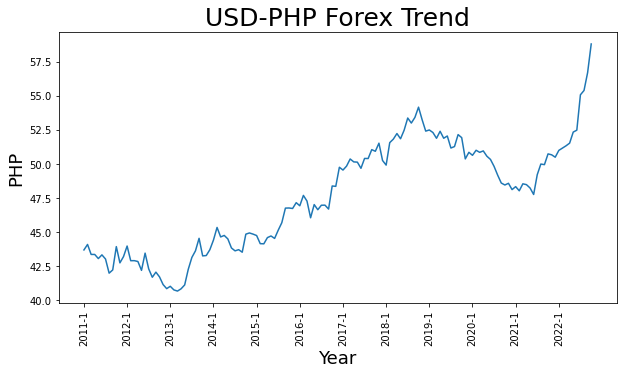

Average

47.6029 PHP

Highest Exchange Rate

2022-10

58.8015 PHP

Lowest Exchange Rate

2013-3

40.6802 PHP

In [26]:
#get philippines - usd historical data
import sqlite3 as sql
import requests as req
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML

#create database
conn= sql.connect('forex.db')
print("Connected to database successfully")

#create cursor
c= conn.cursor()

sumVal = 0
dates= []
histDataUsdPhp= []

def insertData(year, month, data, custom):
    with conn:  #commit the query
        c.execute("INSERT INTO php_data VALUES (:year, :month, :ex_rate, :custom_date)",
                {'year':year, 'month':month, 'ex_rate':data, 'custom_date':custom})

def getData():
    c.execute("SELECT ex_rate FROM php_data")
    return c.fetchall()

def getDate():
    c.execute("SELECT custom_date FROM php_data")
    return c.fetchall()

def removeAllData():
    with conn:
        c.execute("DELETE from php_data")

try:
    # create table
    c.execute("""
                CREATE TABLE php_data(
                year integer,
                month integer,
                ex_rate real,
                custom_date text
                )
                """)

    for i in range(2011, 2023):
        for j in range(1, 13):

            if i==2022 and j==11:
                break
            
            else:
                histDataReq= req.get("https://www.currency-converter.org.uk/currency-rates/historical/rate/USD-PHP-"+"01_"+str(j)+"_"+str(i)+".html?KeepThis=true&TB_iframe=true&height=500&width=500")
                histDatasp= bs(histDataReq.text, 'lxml')
                histTable= histDatasp.find('table')
                histData= histTable.find_all('td')
                data= str(histData[5].text)
                data = data.replace('PHP', '')
                data = float(data)

                insertData(i, j, data, str(i)+'-'+str(j))

                histDataUsdPhp.append(data)
                dates.append(str(i)+'-'+str(j))
                sumVal+=float(data)

except:

    for i in range(0, len(getData())):
        f= getData()[i]
        histDataUsdPhp.append(f[0])

    for i in range(0, len(getDate())):
        f= getDate()[i]
        dates.append(f[0])

    for i in histDataUsdPhp:
        sumVal+=i

finally:
    #plot the data

    # Specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(10,5))
    # Rotate the date ticks on the x-axis by degrees
    plt.xticks(rotation=90)
    # plt.yticks(rotation=180)

    plt.xticks(np.arange(0, len(dates), 12))
    # plt.yticks(np.arange(0, len(histDataUsdPhp), 20))

    # Set title on the axis
    plt.xlabel('Year', fontsize=18, ).set_color('black')
    plt.ylabel('PHP', fontsize=18).set_color('black')
    plt.tick_params(axis='both', color='black')
    # Plot the data
    plt.plot(dates,histDataUsdPhp)

    plt.title("USD-PHP Forex Trend", color='black', fontsize=25)

    plt.show()

    average = sumVal/len(histDataUsdPhp)
    maxVal= max(histDataUsdPhp)
    minVal= min(histDataUsdPhp)

    #find out the date of the max and min value
    dateMax= histDataUsdPhp.index(maxVal)
    dateMax= dates[dateMax]
    dateMin= histDataUsdPhp.index(minVal)
    dateMin= dates[dateMin]

    display(HTML(f"<center><h1>Average</h1></center>"))
    display(HTML(f"<center><h2>{str('%.4f' % average) + ' PHP'}</h2></center>"))
    display(HTML(f"<center><h1>Highest Exchange Rate</h1></center>"))
    display(HTML(f"<center><h2>{str(dateMax)}</h2></center>"))
    display(HTML(f"<center><h2>{str(maxVal) + ' PHP'}</h2></center>"))
    display(HTML(f"<center><h1>Lowest Exchange Rate</h1></center>"))
    display(HTML(f"<center><h2>{str(dateMin)}</h2></center>"))
    display(HTML(f"<center><h2>{str (minVal) + ' PHP'}</h2></center>"))

    conn.close()